<a href="https://colab.research.google.com/github/alibekk93/PWM-for-Secondary-Structure/blob/main/PWM_for_SS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PWM for SS

## Setup

In [1]:
!pip install BIO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from Bio import SeqIO

In [20]:
#@markdown Choose how many types of SS you have

types_of_SS = 'Nucleotides' #@param ['3 types of SS', '8 types of SS', 'Nucleotides']

if types_of_SS == '3 types of SS':
  SS_TYPES = ['C', 'E', 'H']
elif types_of_SS == '8 types of SS':
  SS_TYPES = ['B', 'C', 'E', 'G', 'H', 'I', 'S', 'T']
elif types_of_SS == 'Nucleotides':
  SS_TYPES = ['A', 'C', 'G', 'T']

CHAR_TO_INDEX = {ss:i for i, ss in enumerate(SS_TYPES)}
INDEX_TO_CHAR = {i:ss for i, ss in enumerate(SS_TYPES)}

#@markdown Choose a pseudocount value
pseudocount = '1e-100' #@param {type:'string'}
pseudocount = float(pseudocount)

#@markdown Set motif length

motif_length = 7 #@param {type:'integer'}

#@markdown Set number of iterations
n_iter = 1000 #@param {type:'integer'}

In [28]:
seqs_file = SeqIO.parse('/content/EscherichiaColiK12SubstrDH10B_CDS.FAS', 'fasta')
seqs = [str(seq.seq) for seq in seqs_file][50:100]

In [30]:
# background frequencies and counts
seqs_concat = ''.join(seqs)
background_counts = [seqs_concat.count(ss) for ss in SS_TYPES]
background_freqs = [count / len(seqs_concat) for count in background_counts]
# print({ss:f for ss, f in zip(SS_TYPES, background_freqs)})

# get initial random n-mers
random_nmers = []
for seq in seqs:
  effective_len = len(seq) + 1 - motif_length
  nmer_start = np.random.choice(range(effective_len))
  random_nmer = seq[nmer_start:nmer_start + motif_length]
  random_nmers.append(random_nmer)
# print(random_nmers)

In [31]:
def optimize_nmer(seq_i, seqs=seqs, random_nmers=random_nmers, motif_length=motif_length,
                  background_counts=background_counts, pseudocount=pseudocount):
  # removing optimized nmer
  seq = seqs[seq_i]
  effective_len = len(seq) + 1 - motif_length
  optimized_nmer = random_nmers[seq_i]
  nmers_for_counts = random_nmers.copy()
  nmers_for_counts.remove(nmers_for_counts[seq_i])
  # counting SS in nmers other than optimized
  counts = np.zeros((motif_length, len(SS_TYPES)))
  for nmer in nmers_for_counts:
    for i, char in enumerate(nmer):
      index = CHAR_TO_INDEX[char]
      counts[i, index] += 1
  # adding optimized nmer to background counts
  background_counts_with_nmer = [optimized_nmer.count(ss) + background + pseudocount*4 for ss, background in zip(SS_TYPES, background_counts)]
  # getting background freqs
  background_freqs_with_nmer = [(bc) / (sum(background_counts_with_nmer)) for bc in background_counts_with_nmer]
  # calculating pwm
  pwm = np.zeros_like(counts)
  for i in range(len(SS_TYPES)):
    pwm[:, i] = np.log((counts[:, i]/sum(counts[:, i]) + pseudocount)/(background_freqs_with_nmer[i]))
  # calculate pwms for each nmer in sequence
  pwms_all = []
  for nmer_i in range(effective_len):
    nmer = seq[nmer_i:nmer_i + motif_length]
    pwms_all.append(np.sum([pwm[i, CHAR_TO_INDEX[ss]] for i, ss in enumerate(nmer)]))
    optimal_nmer_i = np.where(pwms_all==max(pwms_all))[0][0]
    random_nmers[seq_i] = seqs[seq_i][optimal_nmer_i:optimal_nmer_i + motif_length]
  return random_nmers, optimal_nmer_i, pwm

In [32]:
# get optimal nmer for each sequence
n_nochange = 0
optimal_nmer_idx = []
max_F = 0
F_values = []
for iter in tqdm(range(n_iter)):
  for seq_i in range(len(seqs)):
    random_nmers, optimal_nmer_i, pwm = optimize_nmer(seq_i)
    optimal_nmer_idx.append(optimal_nmer_i)
  # calculate F
  counts = np.zeros((motif_length, len(SS_TYPES)))
  for nmer in random_nmers:
    for i, char in enumerate(nmer):
      index = CHAR_TO_INDEX[char]
      counts[i, index] += 1
  new_F = sum(sum(counts * pwm))
  F_values.append(new_F)
  if new_F > max_F:
    max_F = new_F
  else:
    n_nochange += 1
  if n_nochange > 10:
    print('Completed after {n} iterations'.format(n=iter))
    break

  1%|▏         | 14/1000 [00:56<1:06:22,  4.04s/it]

Completed after 14 iterations


In [33]:
random_nmers[:10]

['ATTGCCG',
 'ATTGCCG',
 'ATTGCTG',
 'ATTGCCG',
 'ATTGCAG',
 'ATTACCG',
 'ATTATCG',
 'AATGCCG',
 'AATGCAG',
 'ATTACTG']

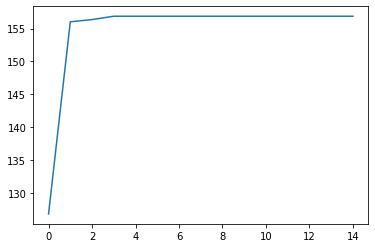

In [34]:
plt.plot(F_values)

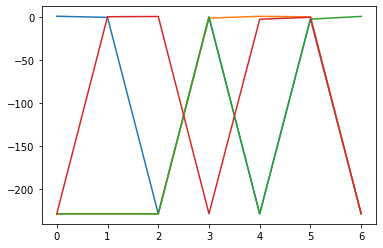

In [35]:
plt.plot(pwm)

In [36]:
F_values

[126.77405512239642,
 156.02664556762412,
 156.36764977557323,
 156.87434563725674,
 156.87434563725674,
 156.87434563725674,
 156.87434563725674,
 156.87434563725674,
 156.87434563725674,
 156.87434563725674,
 156.87434563725674,
 156.87434563725674,
 156.87434563725674,
 156.87434563725674,
 156.87434563725674]

In [37]:
pwm

array([[ 9.59504346e-01, -2.28882636e+02, -2.28990261e+02,
        -2.28782067e+02],
       [-3.67366595e-01, -2.28882636e+02, -2.28990261e+02,
         3.87132542e-01],
       [-2.28821377e+02, -2.28882636e+02, -2.28990261e+02,
         6.95433902e-01],
       [-2.24265751e-01, -1.18907590e+00,  2.31005194e-01,
        -2.28782067e+02],
       [-2.28821377e+02,  8.69312229e-01, -2.28990261e+02,
        -2.50323922e+00],
       [-2.23916877e+00,  2.38040452e-01, -2.40805214e+00,
        -2.00654123e-01],
       [-2.28821377e+02, -2.28882636e+02,  7.90620982e-01,
        -2.28782067e+02]])